In [5]:
from sympy import *
init_printing()

In [6]:
import pandas as pd

# Load cleaned weather data
file_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/dmi_weather_data_cleaned.csv"
df = pd.read_csv(file_path, header=0, parse_dates=["time"], index_col="time")

# Ensure `time` is datetime and remove any timezone info
df.index = pd.to_datetime(df.index).tz_localize(None)

# Load inflow data (KarupBro)
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime (ensure it's properly formatted)
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Set timestamp as index to match `df`
korup_parken_df.set_index("timestamp", inplace=True)

# Drop unnecessary column
korup_parken_df.drop(columns=["BygholmPark"], inplace=True)

# Merge data on the index instead of the column
merged_df = df.join(korup_parken_df, how="left")

# Check result
merged_df.head()

,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,wind_dir_past1h,wind_speed_past1h,wind_gust_always_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob,KarupBro
time,,,,,,,,,,,,,,,,
2002-01-01,-9.3,6.4,1.250000,-0.062500,-0.2,0.1,0.037500,88.708333,281.666667,6.995833,10.587302,2.2,34.0,271.0,0.0,1829.75
2002-01-02,-6.3,6.4,-0.837500,-1.970833,-0.1,0.0,-0.033333,77.583333,110.208333,2.695833,10.685714,0.0,0.0,805.0,328.0,7279.46
2002-01-03,-7.6,-1.0,-5.166667,-6.937500,-0.2,0.0,-0.100000,87.458333,158.625000,1.195833,12.360317,0.0,0.0,739.0,278.5,5261.85
2002-01-04,-9.3,-1.3,-6.025000,-7.950000,-0.7,-0.2,-0.333333,80.916667,221.708333,0.987500,12.968254,0.0,0.0,876.0,355.0,2951.97
2002-01-05,-10.6,3.7,-3.466667,-4.337500,-1.1,-0.4,-0.754167,92.458333,239.750000,1.854167,10.766667,0.1,1.0,659.0,268.5,1868.53


In [7]:
import numpy as np

# Ensure datetime index is correctly formatted
merged_df.index = pd.to_datetime(merged_df.index)

# Extract "day of year" (1-365)
merged_df["day_of_year"] = merged_df.index.dayofyear

# Convert to cyclic features using sine and cosine
merged_df["day_sin"] = np.sin(2 * np.pi * merged_df["day_of_year"] / 365)
merged_df["day_cos"] = np.cos(2 * np.pi * merged_df["day_of_year"] / 365)

# Drop the raw day_of_year column (optional, since sine/cosine replace it)
merged_df.drop(columns=["day_of_year"], inplace=True)

# Check result
merged_df[["day_sin", "day_cos"]].head()

,day_sin,day_cos
time,,
2002-01-01,0.017213,0.999852
2002-01-02,0.034422,0.999407
2002-01-03,0.051620,0.998667
2002-01-04,0.068802,0.997630
2002-01-05,0.085965,0.996298


Epoch 1/50
600/600 [==============================] - 17s 27ms/step - loss: 0.0119 - val_loss: 0.0103
Epoch 2/50
600/600 [==============================] - 16s 26ms/step - loss: 0.0080 - val_loss: 0.0090
Epoch 3/50
600/600 [==============================] - 16s 27ms/step - loss: 0.0077 - val_loss: 0.0123
Epoch 4/50
600/600 [==============================] - 16s 26ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 5/50
600/600 [==============================] - 17s 28ms/step - loss: 0.0067 - val_loss: 0.0082
Epoch 6/50
600/600 [==============================] - 17s 28ms/step - loss: 0.0063 - val_loss: 0.0147
Epoch 7/50
600/600 [==============================] - 15s 26ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 8/50
600/600 [==============================] - 16s 26ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 9/50
600/600 [==============================] - 15s 26ms/step - loss: 0.0057 - val_loss: 0.0117
Epoch 10/50
600/600 [==============================] - 16s 26ms/step - loss: 0.005

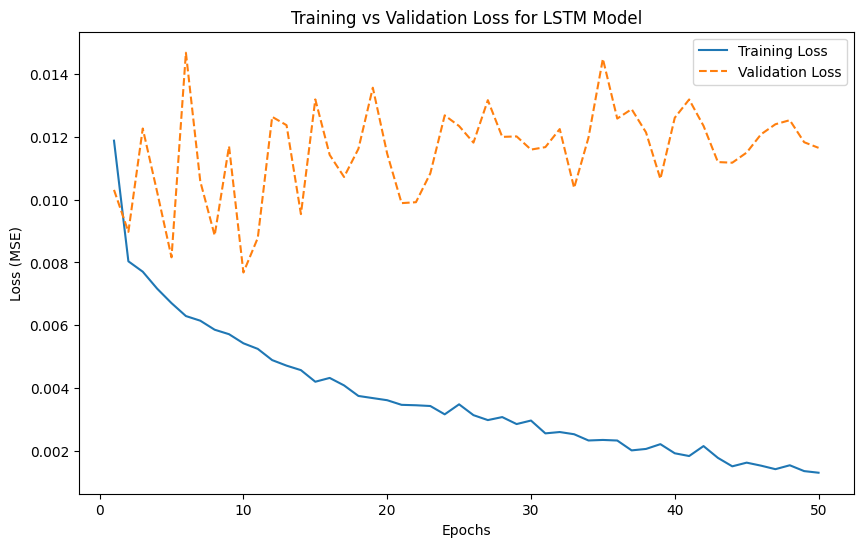

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2


# Define hyperparameters
TIME_STEPS = 30
LSTM_UNITS = 400
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 50  # Increased to allow better learning

def preprocess_data(df, time_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Ensure only numerical features
    X_scaled = scaler_X.fit_transform(df.drop(columns=["KarupBro"]).select_dtypes(include=[np.number]))
    y_scaled = scaler_y.fit_transform(df["KarupBro"].values.reshape(-1, 1))
    
    X_series, y_series = [], []
    for i in range(time_steps, len(X_scaled)):
        X_series.append(X_scaled[i - time_steps:i])
        y_series.append(y_scaled[i])
    
    return np.array(X_series), np.array(y_series), scaler_X, scaler_y

# Build LSTM model
def build_model(time_steps, features, learning_rate):
    model = Sequential([
        LSTM(200, return_sequences=True, input_shape=(time_steps, features)),  # Reduced units
        Dropout(0.3),
        LSTM(100, return_sequences=False),  # Additional smaller LSTM layer
        Dropout(0.3),
        Dense(50, activation="relu"),  # Additional dense layer
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    return model

# Ensure dataset has no missing values
merged_df = merged_df.dropna()

# Prepare dataset
X_series, y_series, scaler_X, scaler_y = preprocess_data(merged_df, TIME_STEPS)

# Split into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_series, y_series, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
FEATURES = X_series.shape[2]

# Build and train model
model = build_model(TIME_STEPS, FEATURES, LEARNING_RATE)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Extract loss values for logging
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Plot train vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_loss, label="Training Loss")
plt.plot(range(1, EPOCHS + 1), val_loss, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss for LSTM Model")
plt.legend()
plt.show()

50/50 [==============================] - 1s 15ms/step


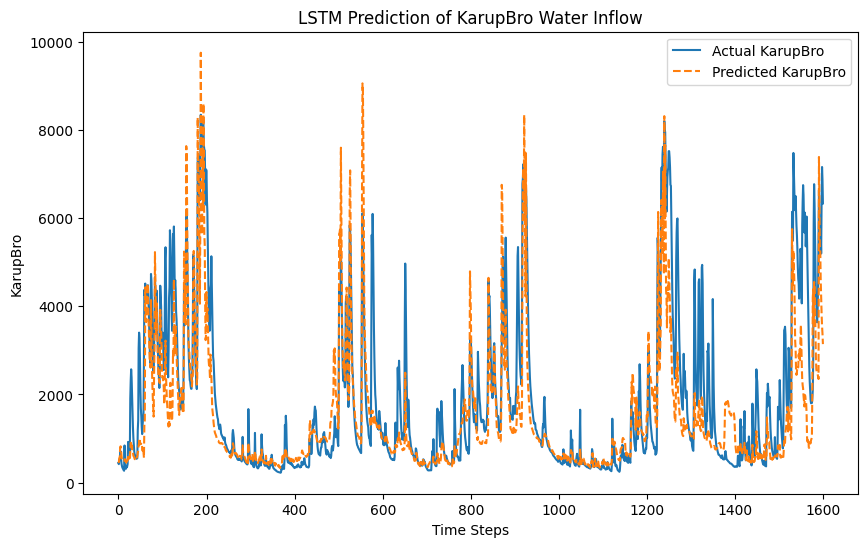

In [10]:
# Predict on test data
y_pred = model.predict(X_test)
y_test_inverse = scaler_y.inverse_transform(y_test)
y_pred_inverse = scaler_y.inverse_transform(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="Actual KarupBro")
plt.plot(y_pred_inverse, label="Predicted KarupBro", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("KarupBro")
plt.title("LSTM Prediction of KarupBro Water Inflow")
plt.legend()
plt.show()